# Evaluation of Best Models on New Bitcoin Fee Data (Mar 5 – May 12)

This notebook evaluates the best-performing model from each class on the latest cleaned dataset:

- Exponential Smoothing (HWES)
- SARIMA
- XGBoost

Each model uses a dedicated preprocessed feature set. Evaluation is done using MAE and RMSE on the test set. Visual comparisons are provided.

## 1. Import Libraries

In [47]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

## 2. Load Preprocessed Datasets

In [3]:
df_hwes = pd.read_parquet("../data/processed/preprocessed_hwes.parquet")
df_sarima = pd.read_parquet("../data/processed/preprocessed_sarima.parquet")
df_xgb = pd.read_parquet("../data/processed/preprocessed_xgboost.parquet")

## 3. Forecasting with Best-Performing Models Across Methods

### 3.1 HWES Model

#### 3.1.1 HWES Model – 15-Minute Interval  
Evaluate performance using the best parameters on the 15-minute preprocessed dataset.


In [36]:
df_15min = df_hwes.resample("15min").mean().interpolate()

# Select target
target_col = "recommended_fee_fastestFee"
series_15min = df_15min[[target_col]]

# Normalize the target to [0, 1]
scaler = MinMaxScaler(feature_range=(1, 2))
series_15min_scaled = scaler.fit_transform(series_15min)
series_15min_scaled = pd.Series(series_15min_scaled.flatten(), index=series_15min.index)

# Step 3: Use last 8 days, split into 7-day train (672 points) and 1-day test (96 points)
series_last_8d = series_15min_scaled[-768:]
train_15 = series_last_8d[:-96]
test_15 = series_last_8d[-96:]

In [37]:
# Step 1: Define parameter grid
# trend_options = ['add', 'mul']
# seasonal_options = ['add', 'mul']
# damped_options = [True, False]

# param_grid = [
#     (t, s, d)
#     for t in trend_options
#     for s in seasonal_options
#     for d in damped_options
#     if not (t == 'mul' or s == 'mul') or (series_15min_scaled > 0).all()
# ]

# # Step 2: Grid search on training set
# best_mae = float('inf')
# best_params = None

# for trend, seasonal, damped in param_grid:
#     try:
#         model = ExponentialSmoothing(
#             train_15,
#             trend=trend,
#             seasonal=seasonal,
#             seasonal_periods=96,
#             damped_trend=damped
#         )
#         fit = model.fit(optimized=True, use_brute=True)
#         forecast = fit.forecast(96)
#         mae = mean_absolute_error(test_15, forecast)

#         if mae < best_mae:
#             best_mae = mae
#             best_params = (trend, seasonal, damped)

#     except Exception as e:
#         print(f"Skipped: {trend}-{seasonal}-{damped} due to {e}")

# Step 3: Retrain final model on full train set using best_params
# best_trend, best_seasonal, best_damped = best_params
final_model = ExponentialSmoothing(
    train_15,
    trend='mul',
    seasonal='mul',
    seasonal_periods=96,
    damped_trend=True
)
final_fit = final_model.fit(optimized=True, use_brute=True)
forecast_final = final_fit.forecast(96)


In [40]:
# Inverse transform
train_15_true = scaler.inverse_transform(train_15.values.reshape(-1, 1)).flatten()
test_15_true = scaler.inverse_transform(test_15.values.reshape(-1, 1)).flatten()
forecast_15 = scaler.inverse_transform(forecast_final.values.reshape(-1, 1)).flatten()

# Evaluation
mae_15 = mean_absolute_error(test_15_true, forecast_15)
rmse_15 = mean_squared_error(test_15_true, forecast_15) ** 0.5
mape_15 = mean_absolute_percentage_error(test_15_true, forecast_15) * 100

print(f"HWES 15min MAE: {mae_15:.2f}")
print(f"HWES 15min RMSE: {rmse_15:.2f}")
print(f"HWES 15min MAPE: {mape_15:.2f}%")

HWES 15min MAE: 5.67
HWES 15min RMSE: 11.81
HWES 15min MAPE: 82.28%


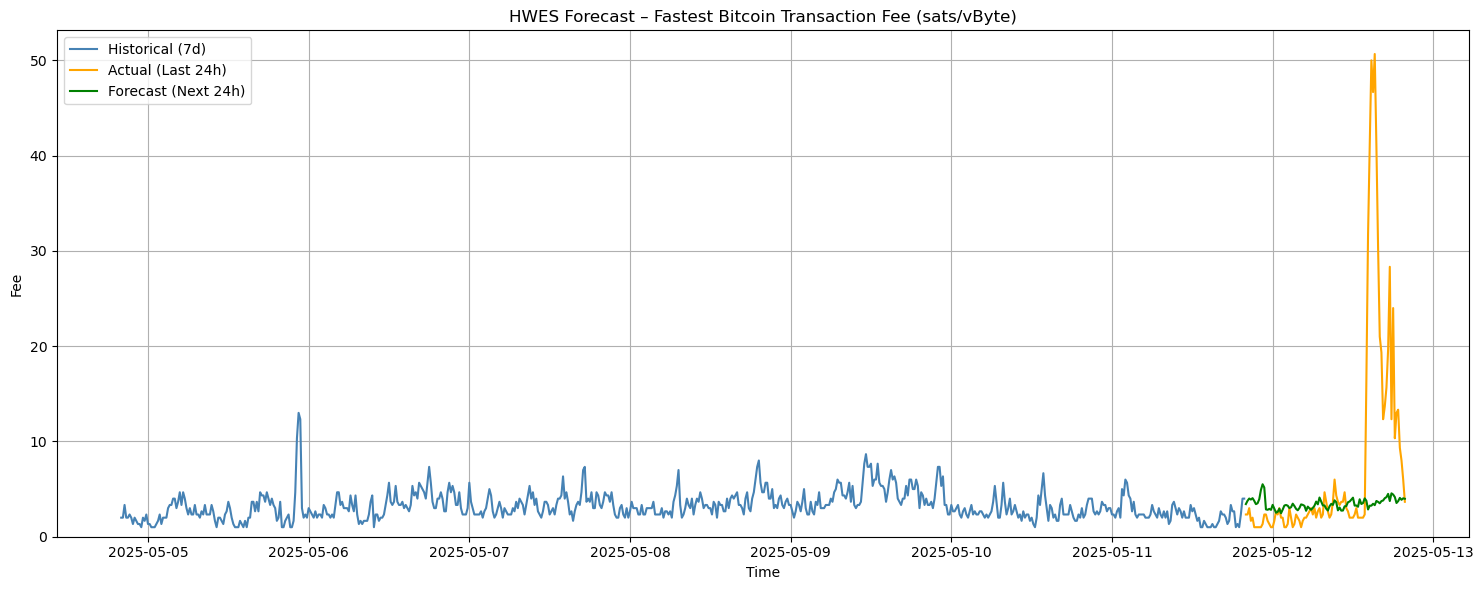

In [41]:
# Plot historical (7d), actual (last 1d), forecast (next 1d)
plt.figure(figsize=(15, 6))
plt.plot(train_15.index, train_15_true, label="Historical (7d)", color="steelblue")
plt.plot(test_15.index, test_15_true, label="Actual (Last 24h)", color="orange")
plt.plot(test_15.index, forecast_15, label="Forecast (Next 24h)", color="green")
plt.title("HWES Forecast – Fastest Bitcoin Transaction Fee (sats/vByte)")
plt.xlabel("Time")
plt.ylabel("Fee")
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### 3.1.2 HWES Model – 30-Minute Interval  
Compare results using the same model on the 30-minute resampled dataset, which may reduce noise and improve generalization.

In [43]:
df_30min = df_hwes.resample("30min").mean().interpolate()

# Select target
target_col = "recommended_fee_fastestFee"
series_30min = df_30min[[target_col]]

# Normalize the target to [0, 1]
scaler = MinMaxScaler(feature_range=(1, 2))
series_30min_scaled = scaler.fit_transform(series_30min)
series_30min_scaled = pd.Series(series_30min_scaled.flatten(), index=series_30min.index)

# Step 3: Use last 8 days, split into 7-day train (336 points) and 1-day test (48 points)
series_last_8d = series_30min_scaled[-384:]
train_30 = series_last_8d[:-48]
test_30 = series_last_8d[-48:]

# Fit HWES with best params
model_30 = ExponentialSmoothing(
    train_30,
    trend='mul',
    seasonal='mul',
    seasonal_periods=48,
    damped_trend=True
)
fit_30 = model_30.fit(optimized=True, use_brute=True)
forecast_scaled = fit_30.forecast(48)

# Inverse transform
forecast_30 = scaler.inverse_transform(forecast_scaled.values.reshape(-1, 1)).flatten()
test_30_true = scaler.inverse_transform(test_30.values.reshape(-1, 1)).flatten()

# Evaluation
mae_30 = mean_absolute_error(test_30_true, forecast_30)
rmse_30 = mean_squared_error(test_30_true, forecast_30) ** 0.5
mape_30 = mean_absolute_percentage_error(test_30_true, forecast_30) * 100

print(f"HWES 30min MAE: {mae_30:.2f}")
print(f"HWES 30min RMSE: {rmse_30:.2f}")
print(f"HWES 30min MAPE: {mape_30:.2f}%")


HWES 30min MAE: 5.46
HWES 30min RMSE: 11.76
HWES 30min MAPE: 57.61%


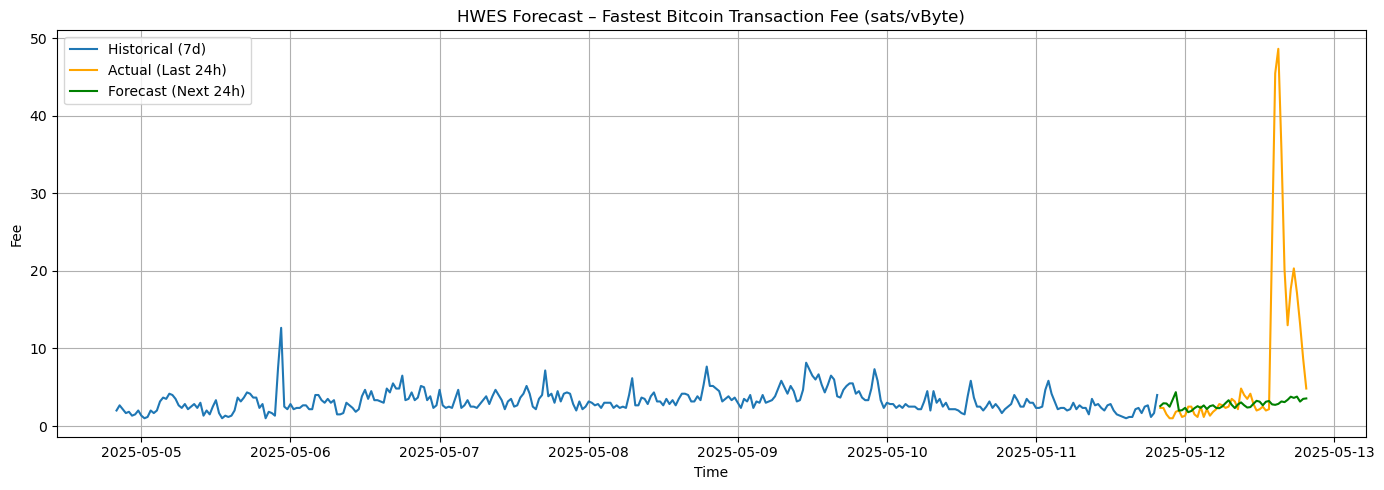

In [44]:
# Plot
plt.figure(figsize=(14, 5))
plt.plot(train_30.index[-48*7:], scaler.inverse_transform(train_30[-48*7:].values.reshape(-1, 1)), label="Historical (7d)")
plt.plot(test_30.index, test_30_true, label="Actual (Last 24h)", color="orange")
plt.plot(test_30.index, forecast_30, label="Forecast (Next 24h)", color="green")
plt.title("HWES Forecast – Fastest Bitcoin Transaction Fee (sats/vByte)")
plt.xlabel("Time")
plt.ylabel("Fee")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 3.2 SARIMA

=== SARIMA Model (7-day train) ===
RMSE: 12.1916
MAE: 5.5737
MAPE: 54.32%

=== Baseline (Median) ===
RMSE: 12.2725
MAE: 5.5660
MAPE: 51.22%


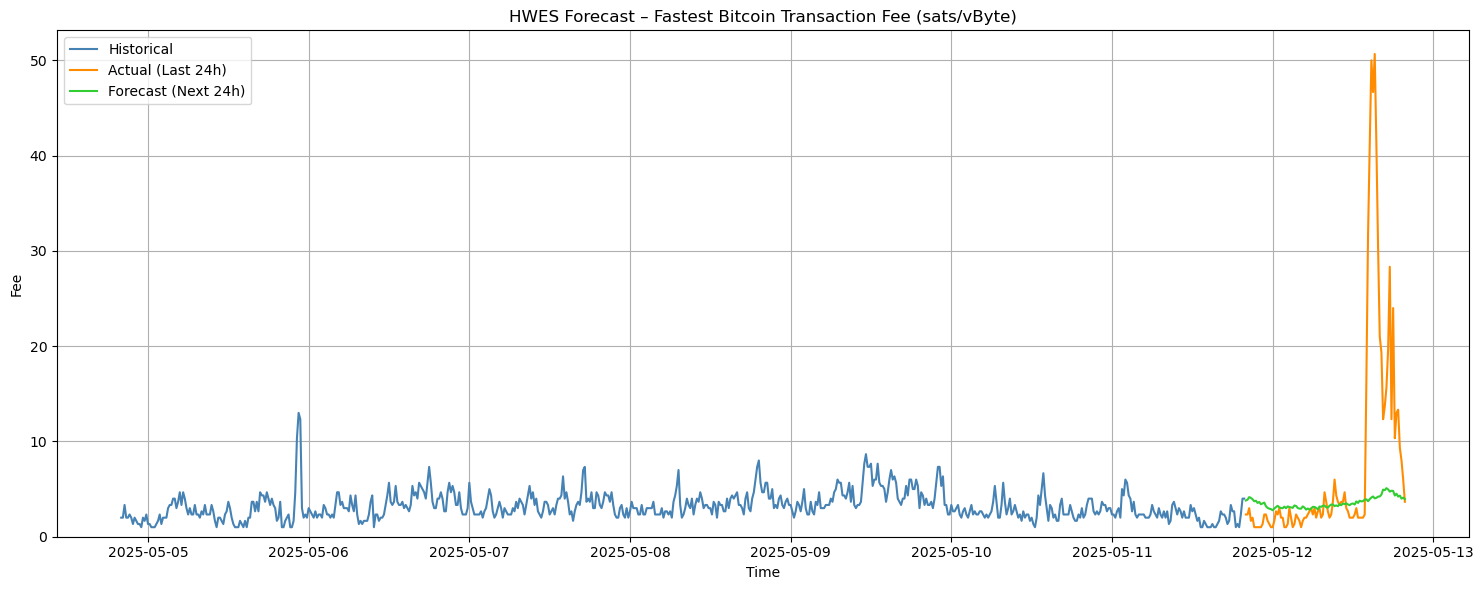

In [34]:
# Use last 8 days (7 for training, 1 for testing)
y = df_sarima["recommended_fee_fastestFee"]

# 15-min interval: 96 points/day, so 8 days = 768 points
y_train = y[-192:-96]   # 192 = 2 days; 96 = 1 day (this gives you 7 days)
y_test = y[-96:]        # last day

# Log transform
y_train_log = np.log1p(y_train)

# Fit SARIMA
forecaster = ARIMA(order=(1, 0, 1), seasonal_order=(1, 0, 1, 96))
forecaster.fit(y_train_log)

# Forecast
fh = list(range(1, 97))
y_pred_log = forecaster.predict(fh=fh)
y_pred = np.expm1(y_pred_log)

# Baseline
baseline_value = y_train.median()
y_pred_baseline = [baseline_value] * 96

# Metrics
rmse = mean_squared_error(y_test, y_pred) ** 0.5
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

baseline_rmse = mean_squared_error(y_test, y_pred_baseline) ** 0.5
baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
baseline_mape = mean_absolute_percentage_error(y_test, y_pred_baseline)

# Print results
print("=== SARIMA Model (7-day train) ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2%}")
print("\n=== Baseline (Median) ===")
print(f"RMSE: {baseline_rmse:.4f}")
print(f"MAE: {baseline_mae:.4f}")
print(f"MAPE: {baseline_mape:.2%}")

# Plot
# Use the last 8 days to extract this 7+1 split
series_recent = series_15min[-96*8:]  # 96 points/day * 8 days
train_15 = series_recent[:-96]        # Last 7 days
test_15 = series_recent[-96:]         # Last day

# Make sure this is the same as your HWES training input
train_sampled = train_15  # For plotting
plt.figure(figsize=(15, 6))
plt.plot(train_sampled.index, train_sampled, label="Historical", color="steelblue")
plt.plot(test_15.index, test_15_true, label="Actual (Last 24h)", color="darkorange")
plt.plot(test_15.index, forecast_15, label="Forecast (Next 24h)", color="limegreen")

plt.title("HWES Forecast – Fastest Bitcoin Transaction Fee (sats/vByte)")
plt.xlabel("Time")
plt.ylabel("Fee")
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



### 3.3 XGBOOST

In [45]:
def add_selected_lags(df, columns, lags=[1, 2, 3, 6, 12]):
    lagged_cols = []
    for col in columns:
        for lag in lags:
            shifted = df[col].shift(lag)
            shifted.name = f"{col}_lag_{lag}"
            lagged_cols.append(shifted)
    df_lags = pd.concat(lagged_cols, axis=1)
    df_combined = pd.concat([df, df_lags], axis=1)
    return df_combined

target_col = "recommended_fee_fastestFee"
exog_cols = [col for col in df_xgb.columns if col != target_col and "mempool_fee_histogram_bin" not in col]

df_lagged = add_selected_lags(df_xgb.copy(), columns=exog_cols, lags=[1, 2, 3, 6, 12])
df_lagged = df_lagged.dropna()

In [46]:
y = df_lagged[target_col]
X = df_lagged.drop(columns=[target_col])

# 7 days (15-min interval → 96 per day → 672 rows)
X_train = X.iloc[-(96+672):-96]
X_test = X.iloc[-96:]
y_train = y.iloc[-(96+672):-96]
y_test = y.iloc[-96:]

In [48]:
best_xgb = xgb.XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=5,
    reg_alpha=5,
    gamma=3,
    n_jobs=-1
)

forecaster = make_reduction(
    estimator=best_xgb,
    window_length=96,  # 1-day lag
    strategy="recursive",
    scitype="infer"
)
fh = ForecastingHorizon(np.arange(1, 97), is_relative=True)
forecaster.fit(y_train, X=X_train)
y_pred = forecaster.predict(fh=fh, X=X_test)


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"XGBoost 15min MAE: {mae:.2f}")
print(f"XGBoost 15min RMSE: {rmse:.2f}")
print(f"XGBoost 15min MAPE: {mape:.2f}%")

XGBoost 15min MAE: 4.95
XGBoost 15min RMSE: 11.33
XGBoost 15min MAPE: 44.80%


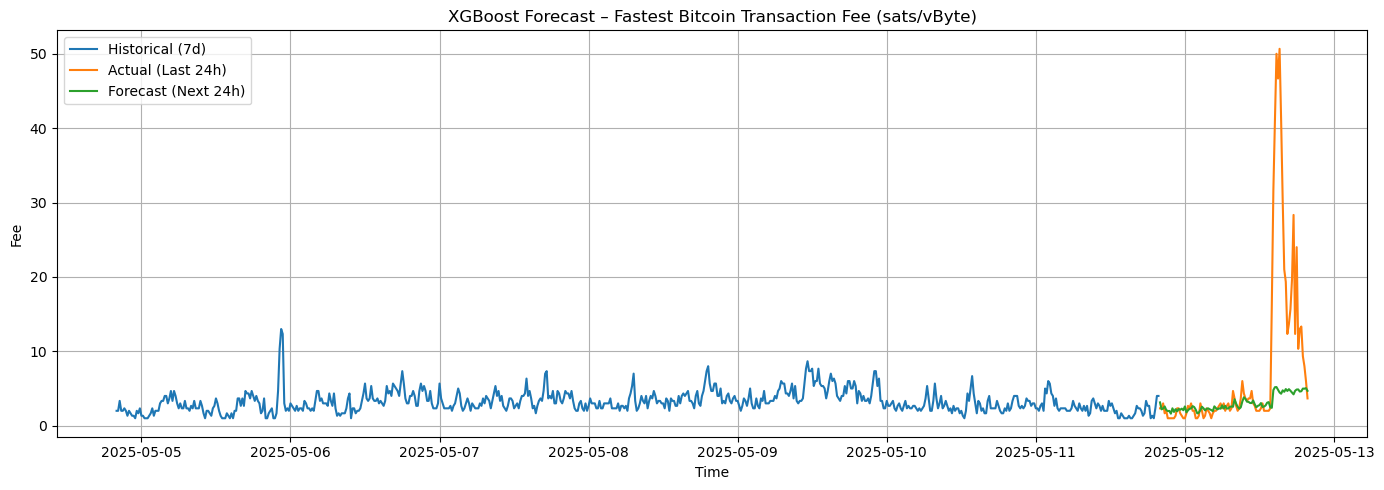

In [50]:
plt.figure(figsize=(14, 5))
plt.plot(y_train.index[-96*7:], y_train[-96*7:], label="Historical (7d)")
plt.plot(y_test.index, y_test, label="Actual (Last 24h)")
plt.plot(y_test.index, y_pred, label="Forecast (Next 24h)")
plt.title("XGBoost Forecast – Fastest Bitcoin Transaction Fee (sats/vByte)")
plt.xlabel("Time")
plt.ylabel("Fee")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()